## Text Similarity: Analyze Data Science Job Postings

11.10.19

(Data: https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us)

In this project, I train a model to classify job postings by assigning corresponding titles to job descriptions. I then use the model to label unlabeled job postings. I identify job titles that do not explicitly mention "data scientist" or "machine learning engineer," but are in essence data science/machine learning jobs.

Topics:
- Text Preprocessing
- Language Modeling (tf-idf, Latent Semantic Analysis)
- Modeling and Evaluation (classification algorithms)

In [1]:
import pandas as pd
import numpy as np
import scipy

import re

import nltk
from nltk.corpus import stopwords

import string

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('alldata.csv')
df.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [3]:
df.shape

(6964, 5)

## Data Preprocessing and Exploration

In [4]:
# Review labels.
df['position'].value_counts()

Data Scientist                                                                                          351
Senior Data Scientist                                                                                    96
Research Analyst                                                                                         64
Data Engineer                                                                                            60
Machine Learning Engineer                                                                                56
Lead Data Scientist                                                                                      31
Research Scientist                                                                                       30
Sr. Data Scientist                                                                                       28
Principal Data Scientist                                                                                 24
Software Engineer           

There are a lot of unique values for job titles. I'll use regular expressions to clean up job titles. I'll then split the data into labeled and unlabeled datasets based on the number of observations with unique job titles.

In [5]:
df['position'] = df['position'].str.lower().str.strip()

In [6]:
df['position']= df['position'].replace(
    regex='.*data scientist.*',value='data_scientist').replace(
    regex='.*research scientist.*',value='research scientist').replace(
    regex='.*machine learning.*',value='machine learning').replace(
    regex='.*research analyst.*',value='research analyst').replace(
    regex='.*data engineer.*',value='data engineer').replace(
    regex='.*product manager.*',value='product manager').replace(
    regex='.*software engineer.*',value='software engineer').replace(
    regex='.*quantitative analyst.*',value='quantitative analyst').replace(
    regex='.*software development engineer.*',value='software engineer').replace(
    regex='.*software developer.*',value='software engineer').replace(
    regex='.*statistic.*',value='statistics').replace(
    regex='.*data analyst.*',value='data analyst').replace(
    regex='.*biologist.*',value='biologist').replace(
    regex='.*business analyst.*',value='business analyst').replace(
    regex='.*research assistant.*',value='research assistant').replace(
    regex='.*research associate.*',value='research associate').replace(
    regex='.*consultant*',value='consultant').replace(
    regex='.*programmer.*',value='programmer').replace(
    regex='.*director, data science.*',value='data science manager').replace(
    regex='.*director of data science.*',value='data science manager').replace(
    regex='.*data science manager.*',value='data science manager').replace(
    regex='.*data analysis manager.*',value='data science manager').replace(
    regex='.*data analysis manager.*',value='data science manager').replace(
    regex='.*vp, data science .*',value='data science manager').replace(
    regex='.*bioinformatics scientist.*',value='scientist').replace(
    regex='.*senior scientist.*',value='scientist').replace(
    regex='.*clinical scientist*',value='scientist').replace(
    regex='.*staff scientist.*',value='scientist').replace(
    regex='.*associate scientist.*',value='scientist').replace(
    regex='.*environmental scientist*',value='scientist').replace(
    regex='.*applied scientist*',value='scientist')

In [7]:
# Create a dataframe with labels.
df_labeled = df.groupby('position').filter(lambda x: len(x) > 10)
df_labeled.shape

(3861, 5)

In [8]:
df_labeled['position'].value_counts()

data_scientist          1261
machine learning         461
software engineer        350
scientist                330
research analyst         317
research scientist       274
data engineer            178
statistics               121
data analyst             118
research associate       113
product manager           98
quantitative analyst      61
data science manager      46
research assistant        38
business analyst          28
biologist                 27
consultant                21
programmer                19
Name: position, dtype: int64

Text(0.5, 1.0, 'Job Postings')

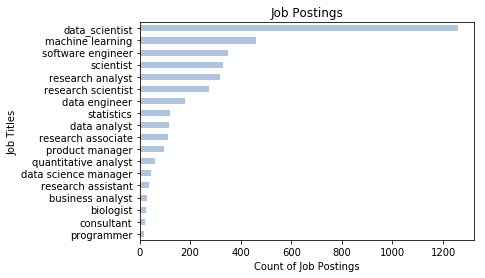

In [9]:
# Explore job postings.
df_labeled.position.value_counts().sort_values().plot(kind = 'barh',color='lightsteelblue')
plt.xlabel('Count of Job Postings')
plt.ylabel('Job Titles')
plt.title('Job Postings')

Text(0.5, 1.0, 'Top 15 Locations')

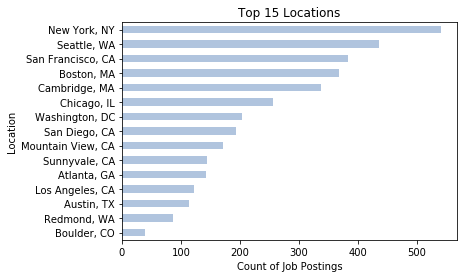

In [10]:
# Explore top locations.
df_labeled['location']= df_labeled['location'].replace(regex='\d',value='').str.strip()

df_labeled.location.value_counts()[:15].sort_values().plot(kind = 'barh',color='lightsteelblue')
plt.xlabel('Count of Job Postings')
plt.ylabel('Location')
plt.title('Top 15 Locations')

Text(0.5, 1.0, 'Top 15 Companies')

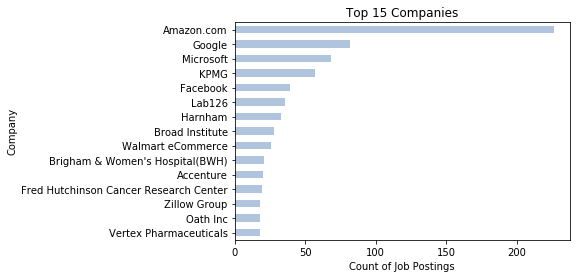

In [11]:
# Explore top companies.
df_labeled.company.value_counts()[:15].sort_values().plot(kind = 'barh',color='lightsteelblue')
plt.xlabel('Count of Job Postings')
plt.ylabel('Company')
plt.title('Top 15 Companies')

In [12]:
# Review sample observations.
df_labeled.loc[df_labeled['position']=='product manager'].head(10)

,position,company,description,reviews,location
207,product manager,DELL,Technical Product Manager\n\nAbout Secureworks...,8380.0,"Atlanta, GA"
220,product manager,DELL,"Senior Product Manager – Secureworks – Austin,...",8380.0,"Atlanta, GA"
241,product manager,BrightBytes,Product Manager (Flexible Location)\n\nAbout B...,NaN,"Atlanta, GA"
455,product manager,VMware,"We are looking for an experienced, Sr. Product...",598.0,"Austin, TX"
910,product manager,Liberty Mutual,Advance your career at Liberty Mutual - A Fort...,2640.0,"Boston, MA"
940,product manager,Wayfair,"At Wayfair, our Product Management team is res...",344.0,"Boston, MA"
941,product manager,"TekPartners, A P2P Company","Product Manager\n\nBoston, MA\n\n**** Only US ...",42.0,"Boston, MA"
959,product manager,Indigo,Indigo is a high growth innovative agriculture...,NaN,"Boston, MA"
965,product manager,Amazon.com,Job Description\nHundreds of millions of custo...,25902.0,"Boston, MA"
987,product manager,DataRobot,DataRobot believes that automation of data sci...,2.0,"Boston, MA"


In [13]:
# Create the 'unlabeled' dataframe with various unique job titles.
df_unlabeled = df.groupby('position').filter(lambda x: len(x) < 10)
df_unlabeled.shape

(3092, 5)

In [14]:
df_labeled.head()

,position,company,description,reviews,location
1,research assistant,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,data_scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,data analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA"
4,machine learning,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"
5,data engineer,McKinsey & Company,Qualifications\nBachelor’s degree in Computer ...,385.0,"Atlanta, GA"


I'll create a dataset for binary classification to determine whether or not the job description is for a "data_scientist" or "other" role.

In [15]:
df_labeled['position']= df_labeled['position'].replace(
    regex='machine learning',value=1).replace(
    regex='data_scientist',value=1).replace(
    regex='data science manager',value=1)

In [16]:
df_labeled.loc[~df_labeled.position.isin([1]), 'position'] = 0

In [17]:
df_labeled['position'].value_counts()

0    2093
1    1768
Name: position, dtype: int64

In [18]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3861 entries, 1 to 6963
Data columns (total 5 columns):
position       3861 non-null int64
company        3861 non-null object
description    3861 non-null object
reviews        2846 non-null float64
location       3861 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 181.0+ KB


In [19]:
df_labeled.describe(include='all')

,position,company,description,reviews,location
count,3861.000000,3861,3861,2846.000000,3861
unique,NaN,1625,3683,NaN,72
top,NaN,Amazon.com,Note: By applying to this position your applic...,NaN,"New York, NY"
freq,NaN,226,6,NaN,541
mean,0.457912,NaN,NaN,3755.279691,NaN
std,0.498290,NaN,NaN,9473.190605,NaN
min,0.000000,NaN,NaN,2.000000,NaN
25%,0.000000,NaN,NaN,22.000000,NaN
50%,0.000000,NaN,NaN,262.000000,NaN
75%,1.000000,NaN,NaN,2473.000000,NaN


In [20]:
df_labeled.head()

,position,company,description,reviews,location
1,0,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,1,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,0,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA"
4,1,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"
5,0,McKinsey & Company,Qualifications\nBachelor’s degree in Computer ...,385.0,"Atlanta, GA"


In [21]:
# Clean up text.
punctuations = string.punctuation

nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

# Tokenizer function.
def spacy_tokenizer(sentence):
    # Create token object.
    mytokens = parser(sentence)
    # Lemmaize each token, lower case.
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != '-PRON-'
                else word.lower_ for word in mytokens]
    # Remove stop words.
    mytokens = [ word for word in mytokens if word not in stop_words
               and word not in punctuations]
    return mytokens

In [22]:
def clean_text(text):
    text = text.strip().lower()

    return text

df_labeled['description'] = df_labeled.apply(lambda row: clean_text(row['description']), axis=1)
df_labeled.head()

,position,company,description,reviews,location
1,0,The Hexagon Lavish,"job description\n\n""the road that leads to acc...",NaN,"Atlanta, GA"
2,1,Xpert Staffing,"growing company located in the atlanta, ga are...",NaN,"Atlanta, GA"
3,0,Operation HOPE,department: program operationsposition locatio...,44.0,"Atlanta, GA"
4,1,Emory University,description\nthe emory university department o...,550.0,"Atlanta, GA"
5,0,McKinsey & Company,qualifications\nbachelor’s degree in computer ...,385.0,"Atlanta, GA"


In [23]:
# Remove common words in job postings.
df_labeled['description'] = df_labeled['description'].str.replace(
    'job description',' ').str.replace('qualifications', ' ').str.replace(
    'education',' ').str.replace('skills', ' ').str.replace(
    'abilities', ' ').str.replace('description',' ').str.replace(
    'responsibilities', ' ').str.replace('\\n','.').str.replace(
    'amp;', '').str.replace('\*', '').str.strip()

In [24]:
# # Bag of words.
# bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [25]:
# TF-IDF.
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

## Modeling and Evaluation

In [26]:
X = df_labeled['description']
ylabels = df_labeled['position']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [27]:
# Pipeline and model.
classifier = LogisticRegression()

pipe = Pipeline([('vectorizer', tfidf_vector),
                ('classifier', classifier)])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...\\b',
                                 tokenizer=<function spacy_tokenizer at 0x11ac3db90>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [28]:
predicted = pipe.predict(X_test)

print('Training set score:', pipe.score(X_train, y_train))
print('Test set score:', pipe.score(X_test, y_test))

print('\nTest set scores:')
print('Precision:', metrics.precision_score(y_test, predicted))
print('Recall:', metrics.recall_score(y_test, predicted))

Training set score: 0.9307920059215397
Test set score: 0.8559102674719585

Test set scores:
Precision: 0.8363970588235294
Recall: 0.8536585365853658


## Review of Predictions

In [29]:
predicted

array([0, 0, 1, ..., 0, 0, 0])

In [30]:
df_test = pd.concat([X_test,y_test], axis=1)

In [31]:
df_test.head()

,description,position
2613,"by clicking the “apply” button, i understand t...",0
2473,this position is expected to understand the in...,0
6490,imagine a world where smartphones are used to ...,1
6570,"one of the leaders in the iot space, located i...",1
6882,position .this position is in the walmart per...,0


In [32]:
df_test['predicted'] = predicted

In [33]:
# Review labels and predictions.
df_test.tail(50)

,description,position,predicted
808,"as a not-for-profit organization, partners hea...",1,0
1283,"overview.currently, we are in search of a high...",1,1
6405,"janssen research & development, llc., a johnso...",0,0
1299,the expertise we’re looking for.master’s in en...,1,1
5256,.hundreds of millions of customers. billions o...,0,0
3011,why join us?.to be a hero for our rare disease...,0,0
4125,overview.software and data engineer.at hospita...,0,0
5295,organization and job id..job id: 308056..direc...,0,0
6780,..amazon lab126 is an inventive research and d...,0,0
949,you will design and develop machine learning s...,1,1


In [36]:
# Review sample misclassified job descriptions.
df_test['description'][3547] # classifies as a data scientist job

"medidata's unified platform, pioneering analytics, and unrivaled expertise power the development of new therapies for over 1,000 pharmaceutical companies, biotech, medical device firms, academic medical centers and contract research organizations around the world. the medidata clinical cloud® connects patients, physicians and life sciences professionals. companies on the medidata platform are individually and collaboratively reinventing the way research is done to create smarter, more precise treatments. for more information: www.mdsol.com..we know that diverse teams win and are fully committed to selecting leaders and employees that represent the markets in which we operate. we are still led by our co-founders, tarek sherif and glen de vries, and have global operations in us, europe and asia with over 2000 employees...your mission:.genomic data scientist is a key role in a dynamic team of computational biologists, statisticians, computer scientists, data analysts, and business expert

In [37]:
df_test['description'][3846] # classifies as a data scientist job

"known for being a great place to work and build a career, kpmg provides audit, tax and advisory services for organizations in today's most important industries. our growth is driven by delivering real results for our clients. it's also enabled by our culture, which encourages individual development, embraces an inclusive environment, rewards innovative excellence and supports our communities. with qualities like those, it's no wonder we're consistently ranked among the best companies to work for by fortune magazine, consulting magazine, working mother magazine, diversity inc. and others. if you're as passionate about your future as we are, join our team..kpmg is currently seeking a data visualization software engineer to join our advanced data analytics organization.. :.work in cross-disciplinary teams with kpmg industry experts, data scientists, and software engineers to gauge client needs for consuming analytics, understand user profiles, competencies, and priorities.utilize analyti

In [38]:
df_test['description'][808] # misses to classify as a data scientist job

'as a not-for-profit organization, partners healthcare is committed to supporting patient care, research, teaching, and service to the community by leading innovation across our system. founded by brigham and women’s hospital and massachusetts general hospital, partners healthcare supports a complete continuum of care including community and specialty hospitals, a managed care organization, a physician network, community health centers, home care and other health-related entities. several of our hospitals are teaching affiliates of harvard medical school, and our system is a national leader in biomedical research....we’re focused on a people-first culture for our system’s patients and our professional family. that’s why we provide our employees with more ways to achieve their potential. partners healthcare is committed to aligning our employees’ personal aspirations with projects that match their cap  and creating a culture that empowers our managers to become trusted mentors. we suppo

## Classify Observations without Labels

I'll now use the model to classify jobs with a lot of unique job titles. Seeing predictions could save one time opening job descriptions to determine whether or not the job suits their job search. It also helps find job postings that a person could otherwise overlook.

In [39]:
df_unlabeled.head()

,position,company,description,reviews,location
0,development director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
6,"product specialist - periscope, new ventures",McKinsey & Company,Qualifications\nBachelor’s degree\n5-7 years o...,385.0,"Atlanta, GA 30318"
8,analyst - cib credit research,SunTrust,Works closely with senior CIB professionals. P...,3343.0,"Atlanta, GA"
11,health scientist iii-cpts,Chenega Corporation,"Chenega Professional &amp; Technical Services,...",390.0,"Atlanta, GA"
13,assistant scientist (ar) som,Emory University,"DESCRIPTION\nUnder minimal supervision, the As...",550.0,"Atlanta, GA"


### Data preprocessing

In [40]:
df_unlabeled['description'] = df_unlabeled.apply(lambda row: clean_text(row['description']), axis=1)
df_unlabeled.head()

,position,company,description,reviews,location
0,development director,ALS TDI,development director\nals therapy development ...,NaN,"Atlanta, GA 30301"
6,"product specialist - periscope, new ventures",McKinsey & Company,qualifications\nbachelor’s degree\n5-7 years o...,385.0,"Atlanta, GA 30318"
8,analyst - cib credit research,SunTrust,works closely with senior cib professionals. p...,3343.0,"Atlanta, GA"
11,health scientist iii-cpts,Chenega Corporation,"chenega professional &amp; technical services,...",390.0,"Atlanta, GA"
13,assistant scientist (ar) som,Emory University,"description\nunder minimal supervision, the as...",550.0,"Atlanta, GA"


In [41]:
# Remove common words in job postings.
df_unlabeled['description'] = df_unlabeled['description'].str.replace(
    'job description',' ').str.replace('qualifications', ' ').str.replace(
    'education',' ').str.replace('skills', ' ').str.replace(
    'abilities', ' ').str.replace('description',' ').str.replace(
    'responsibilities', ' ').str.replace('\\n','.').str.replace(
    'amp;', '').str.replace('\*', '').str.strip()

### Predictions

In [42]:
predicted = pipe.predict(df_unlabeled['description'])

In [43]:
predicted = pipe.predict(df_unlabeled['description'])

df_unlabeled['predicted'] = predicted
df_unlabeled.head(10)

,position,company,description,reviews,location,predicted
0,development director,ALS TDI,development director.als therapy development i...,NaN,"Atlanta, GA 30301",0
6,"product specialist - periscope, new ventures",McKinsey & Company,.bachelor’s degree.5-7 years of experience in ...,385.0,"Atlanta, GA 30318",0
8,analyst - cib credit research,SunTrust,works closely with senior cib professionals. p...,3343.0,"Atlanta, GA",0
11,health scientist iii-cpts,Chenega Corporation,"chenega professional & technical services, llc...",390.0,"Atlanta, GA",0
13,assistant scientist (ar) som,Emory University,".under minimal supervision, the assistant acad...",550.0,"Atlanta, GA",0
14,business intelligence data science analyst - s...,Newell Brands,data science analyst– business intelligence.lo...,912.0,"Atlanta, GA",1
16,senior structural engineer-transmission & dist...,Burns & McDonnell,.executes complex assignments requiring the us...,152.0,"Atlanta, GA 30309",0
17,senior mobile developer (ios/android),Perficient,overview....at perficient you’ll deliver missi...,44.0,"Atlanta, GA 30338",0
20,senior electrical engineer,Burns & McDonnell,.burns & mcdonnell is considered the leading c...,152.0,"Atlanta, GA 30309",0
21,"sr. manager, full stack development, kpmg tax ...",KPMG,known for being a great place to work and buil...,4494.0,"Atlanta, GA 30338",1


In [44]:
df_unlabeled['predicted'].value_counts()

0    2700
1     392
Name: predicted, dtype: int64

I have additional 392 jobs that one can apply for when looking for a data science job. Some examples below:

In [45]:
df_unlabeled.loc[df_unlabeled['predicted'] == 1][:20]

,position,company,description,reviews,location,predicted
14,business intelligence data science analyst - s...,Newell Brands,data science analyst– business intelligence.lo...,912.0,"Atlanta, GA",1
21,"sr. manager, full stack development, kpmg tax ...",KPMG,known for being a great place to work and buil...,4494.0,"Atlanta, GA 30338",1
40,"data science specialist - periscope, new ventures",McKinsey & Company,".advanced degree (mba, ms, phd, etc.) in econo...",385.0,"Atlanta, GA 30318",1
54,"vp, data analytics",TCGplayer,.vp of data analytics...as we're a highly coll...,NaN,"Atlanta, GA",1
55,lead decision scientist,"Moxie Interactive, Inc.","leading the use of modeling, algorithms, and c...",NaN,"Atlanta, GA 30313",1
58,lead decision scientist,Moxie,"..leading the use of modeling, algorithms, and...",347.0,"Atlanta, GA",1
83,si coe iot data modeling architect,Xylem,xylem (xyl) is a leading global water technolo...,257.0,"Atlanta, GA",1
94,lead r & d engineer/scientist,Honeywell,driving infinite possibilities within a divers...,6121.0,"Atlanta, GA 30308",1
98,data science instructor,General Assembly,"since 2011, general assembly has transformed t...",144.0,"Atlanta, GA",1
121,"business intelligence analyst, people analytic...",McKinsey & Company,.bachelor's or graduate degree with focus in d...,385.0,"Atlanta, GA 30318",1


## Summary

In this project, I worked with a dataset of almost 7000 "data science" jobs. The dataset was scraped from Indeed and contains a lot of job postings that do not fit actual data science job description, e.g. "research assistant" or "scientist."

I split the dataset into labeled and unlabeled sets and worked with the labeled dataset to train a model to distinguish between data science and non-data science jobs. I then used the model and applied it to the unlabeled set of data and identified about 400 jobs that a person looking for a data science job can apply for. 

Knowing which job postings are actual data science jobs can help one save time when looking and applying for jobs. it also prevents one from missing jobs with unstraightforward titles such as "security scientist," "decision scientist," "product owner" or "head of data" that one with data science skills can apply for.